In [ ]:
from glob import glob
import os
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#os.environ['CUDA_VISIBLE_DEVICES'] = "0,1"

In [ ]:
import tensorflow as tf
from keras.applications import Xception
from keras.utils import multi_gpu_model


Using TensorFlow backend.


In [ ]:
path_to_train = './hdd/train_aug'
glob_train_imgs = os.path.join(path_to_train, '*_sat.jpg')
glob_train_masks = os.path.join(path_to_train, '*_msk.png')

train_img_paths = glob(glob_train_imgs)
train_mask_paths = glob(glob_train_masks)

def get_img_id(img_path):
    img_basename = os.path.basename(img_path)
    img_id = os.path.splitext(img_basename)[0][:-len('_sat')]
    return img_id

def image_gen(img_paths, img_size=(512,512)):
    # Iterate over all the image paths
    for img_path in img_paths:
        
        # Construct the corresponding mask path
        img_id = get_img_id(img_path)
        mask_path = os.path.join(path_to_train, img_id + '_msk.png')
        
        # Load the image and mask, and normalize it to 0-1 range
        img = imread(img_path) / 255.
        mask = imread(mask_path, as_gray=True)
        # Resize the images
      #  img = resize(img, img_size, preserve_range=True)
      #  mask = resize(mask, img_size, mode='constant', preserve_range=True)
       # mask = rgb2gray(mask)
      #  print(mask.shape)
        # Turn the mask back into a 0-1 mask
     #   mask = (mask >= 0.5).astype(float)
        
        # Yield the image mask pair
        yield img, mask


# Keras takes its input in batches 
# (i.e. a batch size of 32 would correspond to 32 images and 32 masks from the generator)
# The generator should run forever
def image_batch_generator(img_paths, batchsize=8):
    while True:
        ig = image_gen(img_paths)
        batch_img, batch_mask = [], []
        
        for img, mask in ig:
            # Add the image and mask to the batch
            batch_img.append(img)
            batch_mask.append(mask)
            # If we've reached our batchsize, yield the batch and reset
            if len(batch_img) == batchsize:
                yield np.stack(batch_img, axis=0), np.stack(batch_mask, axis=0)
                batch_img, batch_mask = [], []
        
        # If we have an nonempty batch left, yield it out and reset
        if len(batch_img) != 0:
            yield np.stack(batch_img, axis=0), np.stack(batch_mask, axis=0)
            batch_img, batch_mask = [], []   

In [ ]:
len(train_img_paths)

17461

In [ ]:
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy

smooth = 1.

# This is the competition metric implemented using Keras
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * (K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

# We'll construct a Keras Loss that incorporates the DICE score
def dice_loss(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return  1. - (2. * intersection + 1.) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.)




In [ ]:
from sklearn.model_selection import train_test_split

BATCHSIZE = 8

# Split the data into a train and validation set
#train_img_paths, val_img_paths = train_test_split(train_img_paths, test_size=0.15)

# Create the train and validation generators
#traingen = image_batch_generator(train_img_paths, batchsize=BATCHSIZE)
#valgen = image_batch_generator(val_img_paths, batchsize=BATCHSIZE)

def calc_steps(data_len, batchsize):
    return (data_len + batchsize - 1) // batchsize

# Calculate the steps per epoch
#train_steps = calc_steps(len(train_img_paths), BATCHSIZE)
#val_steps = calc_steps(len(val_img_paths), BATCHSIZE)

from keras.layers import Conv2D, Reshape, MaxPooling2D, Dropout, UpSampling2D, Input, concatenate
from keras.models import Sequential, Model
from keras.optimizers import Adam

#using U-Net for image segmentation
def unet(pretrained_weights = None,input_size = (512,512,3)):
    inputs = Input((512,512,3))
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)
    up6 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    up7 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    up8 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    up9 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)
    
    output = Reshape((512,512))(conv10)
    
    
    model = Model(input = inputs, output = output)
    model.compile(optimizer = Adam(lr = 0.0001), loss = 'binary_crossentropy' , metrics = [dice_coef,'accuracy','mse'])
    
    if(pretrained_weights):
        model.load_weights(pretrained_weights)
        
    return model


In [ ]:

from sklearn.datasets import make_moons
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint


from matplotlib import pyplot
from keras.models import load_model


In [ ]:

model=unet()
from sklearn.model_selection import KFold
kf = KFold(n_splits=8)
i = 1
for train, test in kf.split(train_img_paths):
    print("Fold ",i)
    train_path=np.array(train_img_paths)
    traingen = image_batch_generator(train_path[train], batchsize=BATCHSIZE)
    valgen = image_batch_generator(train_path[test], batchsize=BATCHSIZE)
    train_steps = calc_steps(len(train_path[train]), BATCHSIZE)
    val_steps = calc_steps(len(train_path[test]), BATCHSIZE)
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    mc = ModelCheckpoint('best_model_augkfold.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
    history = model.fit_generator(
        traingen, 
        steps_per_epoch=train_steps, 
        epochs=10, # Change this to a larger number to train for longer
        validation_data=valgen, 
        validation_steps=val_steps, 
        verbose=1,
        max_queue_size=5 ,callbacks = [es,mc])
    
    model.save_weights('best_model_augkfold.h5')
    
    model=unet(pretrained_weights = model.load_weights('best_model_augkold.h5'),input_size = (512,512,3))
    i += 1
    
    


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("re...)`


Fold  1
Epoch 1/10
1910/1910 [==============================] - 3591s 2s/step - loss: 0.1190 - dice_coef: 0.1922 - acc: 0.9644 - mean_squared_error: 0.0305 - val_loss: 0.0907 - val_dice_coef: 0.3839 - val_acc: 0.9687 - val_mean_squared_error: 0.0246

Epoch 00001: val_acc improved from -inf to 0.96866, saving model to best_model_augkfold.h5
Epoch 2/10
1910/1910 [==============================] - 3541s 2s/step - loss: 0.0779 - dice_coef: 0.5343 - acc: 0.9720 - mean_squared_error: 0.0215 - val_loss: 0.0780 - val_dice_coef: 0.5053 - val_acc: 0.9723 - val_mean_squared_error: 0.0213

Epoch 00002: val_acc improved from 0.96866 to 0.97234, saving model to best_model_augkfold.h5
Epoch 3/10
1910/1910 [==============================] - 3488s 2s/step - loss: 0.0681 - dice_coef: 0.6037 - acc: 0.9750 - mean_squared_error: 0.0190 - val_loss: 0.0754 - val_dice_coef: 0.5326 - val_acc: 0.9738 - val_mean_squared_error: 0.0201

Epoch 00003: val_acc improved from 0.97234 to 0.97377, saving model to best_mo

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
model=unet()

history = model.fit_generator(
    traingen, 
    steps_per_epoch=train_steps, 
    epochs=10, # Change this to a larger number to train for longer
    validation_data=valgen, 
    validation_steps=val_steps, 
    verbose=1,
    max_queue_size=5, # Change this number based on memory restrictions
    callbacks=[es,mc]
)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("re...)`


Epoch 1/10
1158/1158 [==============================] - 2186s 2s/step - loss: 0.1342 - dice_coef: 6.4664e-05 - acc: 0.9618 - mean_squared_error: 0.0334 - val_loss: 0.0974 - val_dice_coef: 3.2620e-05 - val_acc: 0.9622 - val_mean_squared_error: 0.0267

Epoch 00001: val_acc improved from -inf to 0.96218, saving model to best_model.h5
Epoch 2/10
1158/1158 [==============================] - 2153s 2s/step - loss: 0.0886 - dice_coef: 0.3682 - acc: 0.9679 - mean_squared_error: 0.0243 - val_loss: 0.0775 - val_dice_coef: 0.4613 - val_acc: 0.9716 - val_mean_squared_error: 0.0215

Epoch 00002: val_acc improved from 0.96218 to 0.97164, saving model to best_model.h5
Epoch 3/10
1158/1158 [==============================] - 2155s 2s/step - loss: 0.0753 - dice_coef: 0.5461 - acc: 0.9727 - mean_squared_error: 0.0208 - val_loss: 0.0697 - val_dice_coef: 0.5594 - val_acc: 0.9746 - val_mean_squared_error: 0.0193

Epoch 00003: val_acc improved from 0.97164 to 0.97462, saving model to best_model.h5
Epoch 4/10


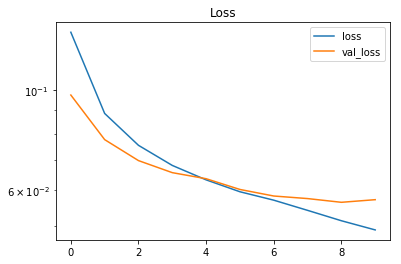

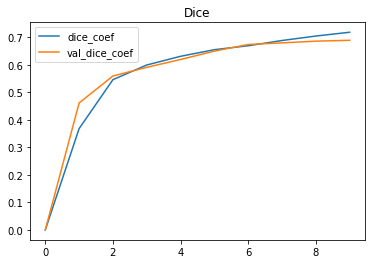

In [ ]:
from keras.models import load_model
 
model.save('best_model.h5')  # creates a HDF5 file 

import pandas as pd
pd.DataFrame(history.history)[['loss', 'val_loss']].plot(title="Loss", logy=True)
pd.DataFrame(history.history)[['dice_coef', 'val_dice_coef']].plot(title="Dice")
    

In [ ]:
from keras.models import load_model

model = load_model('satellite_model_512_10.h5')

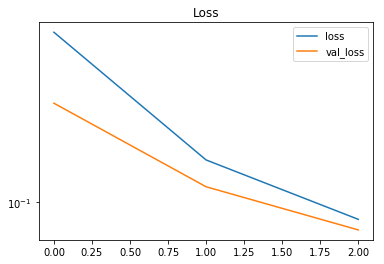

In [ ]:
import pandas as pd
pd.DataFrame(history.history)[['loss', 'val_loss']].plot(title="Loss", logy=True)


In [ ]:

path_to_test = './hdd/val'
glob_test_imgs = os.path.join(path_to_test, '*_sat.jpg')
test_img_paths = glob(glob_test_imgs)

def test_gen(test_img_paths, img_size=(512, 512)):
    for test_img_path in test_img_paths:
        test_img = imread(test_img_path) / 255.
      #  test_img = resize(test_img, img_size, preserve_range=True)
        yield test_img

def test_batch_generator(test_img_paths, batchsize= 8):
    while True:
        ig = test_gen(test_img_paths)
        batch_test = []
        
        for img in ig:
            # Add the image and mask to the batch
            batch_test.append(img)
            # If we've reached our batchsize, yield the batch and reset
            if len(batch_test) == batchsize:
                yield np.stack(batch_test, axis=0)
                batch_test = []
        
        # If we have an nonempty batch left, yield it out and reset
        if len(batch_test) != 0:
            yield np.stack(batch_test, axis=0)
            batch_test = []

BATCHSIZE =8
testgen = test_batch_generator(test_img_paths, batchsize=BATCHSIZE)
test_steps = calc_steps(len(test_img_paths), BATCHSIZE)
pred_test = model.predict_generator(testgen, steps=test_steps, verbose=1, max_queue_size=5)


272/272 [==============================] - 181s 666ms/step


In [ ]:
np.shape(pred_test)

(2169, 512, 512)

In [ ]:
pred_test_new = np.array(pred_test)

In [ ]:
np.max(pred_test)

1.0

In [ ]:
np.min(pred_test)

2.5715525e-18

(array([240548.,   5302.,   3931.,   2818.,   2020.,   1562.,   1627.,
          1544.,   1617.,   1175.]),
 array([1.7552299e-10, 9.7139247e-02, 1.9427849e-01, 2.9141775e-01,
        3.8855699e-01, 4.8569623e-01, 5.8283550e-01, 6.7997473e-01,
        7.7711397e-01, 8.7425321e-01, 9.7139245e-01], dtype=float32),
 <a list of 10 Patch objects>)

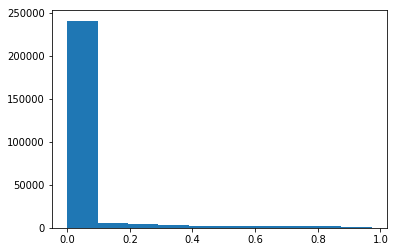

In [ ]:
plt.hist(pred_test_new[0].reshape(np.dot(512,512),))

In [ ]:
pred_test_new[pred_test_new<0.4] = 0
pred_test_new[pred_test_new>=0.4] = 1

In [ ]:
np.shape(pred_test_new)

(2169, 512, 512)

In [ ]:
np.max(pred_test_new[3])

0.99225533

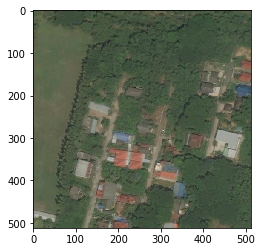

In [ ]:
a = imread(test_img_paths[9])
plt.imshow(a)

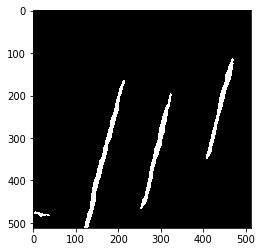

In [ ]:
plt.imshow(pred_test_new[9],cmap="gray")

In [ ]:
import skimage.io as io

test_ids = [get_img_id(i) for i in test_img_paths]

save_path = './val_pred_512_3'
for i,item in enumerate(new):
    test_id = float(test_ids[i])
    io.imsave(os.path.join(save_path,"%d_predict.png"%test_id),item)

/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./val_pred_512_3/77494_predict.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./val_pred_512_3/74091_predict.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./val_pred_512_3/71767_predict.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./val_pred_512_3/73102_predict.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./val_pred_512_3/71771_predict.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_

In [ ]:

# Create submission DataFrame
def create_submission(csv_name, predictions, image_ids):
    """
    csv_name -> string for csv ("XXXXXXX.csv")
    predictions -> numpyarray of size (num_examples, height, width)
                In this case (num_examples, 512, 512)
    image_ids -> numpyarray or list of size (num_examples,)
    
    predictions[i] should be the prediction of road for image_id[i]
    """
    sub = pd.DataFrame()
    sub['ImageId'] = image_ids
    encodings = []
    num_images = len(image_ids)
    for i in range(num_images):
        if (i+1) % (num_images//10) == 0:
            print(i, num_images)
        encodings.append(rle_encoding(predictions[i]))
        
    sub['EncodedPixels'] = encodings
    #sub['Height'] = [512]*num_images #Nonger needed for DICE Scoring
    #sub['Width'] = [512]*num_images #Nonger needed for DICE Scoring
    sub.to_csv(csv_name, index=False)

# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    """
    x = numpyarray of size (height, width) representing the mask of an image
    if x[i,j] == 0:
        image[i,j] is not a road pixel
    if x[i,j] != 0:
        image[i,j] is a road pixel
    """
    dots = np.where(x.T.flatten() != 0)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): 
            run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths


#path_to_pred = './val_pred_512_3/'
#glob_pred_imgs = os.path.join(path_to_pred, '*_predict.png')
#pred_img_paths = glob(glob_pred_imgs)

#prediction1 = []
#test_ids1 = []
#for i in pred_img_paths:
#    prediction1.append(imread(i)/np.max(imread(i)))
#    basename = os.path.basename(i)
#    img_id = os.path.splitext(basename)[0][:-len('_predict')]
#    test_ids1.append(img_id)
#prediction1 = np.stack(prediction1, axis = 0)
#test_ids1 = np.stack(test_ids1, axis = 0)

test_ids = [get_img_id(i) for i in test_img_paths]

create_submission("result_unet_8b_10e_0.4.csv",pred_test_new,test_ids)

215 2169
431 2169
647 2169
863 2169
1079 2169
1295 2169
1511 2169
1727 2169
1943 2169
2159 2169
